In [285]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error
from scipy import stats
import os

In [286]:
# file = pd.read_excel("Files/Data/ComputoGobernador2015_Casilla (1).xlsx", sheet_name = "POR CASILLA", skiprows=1,skipfooter=1) # Alexis
file = pd.read_csv("Files/Data/ComputoGobernador2015_Casilla (1).csv")
muestra_actual = pd.read_csv("Files/Exports/PAQUETES.csv")

In [287]:
muestra_actual

,LLEGADA,DISTRITO.LOCAL,MUNICIPIO,SECCION,CASILLA,PAN,PRI,PRD,PVEM,PT,PANAL,MORENA,HUMANISTA,ENCUENTRO.SOCIAL,PRI.PVEM.PANAL,PRI.PVEM,PRI.PANAL,PVEM.PANAL,COALICION,CANDIDATO.NO.REGISTRADO,VOTOS.NULOS,TOTAL.VOTOS.VALIDOS,VOTACION.TOTAL.EMITIDA
0,216.0,OBREGON CENTRO XVII,CAJEME,961.0,BASICA,195.0,150.0,1.0,1.0,3.0,1.0,11.0,0.0,0.0,0.0,8.0,0.0,0.0,160.0,0.0,3.0,370.0,373.0
1,228.0,HERMOSILLO NORESTE X,HERMOSILLO,361.0,CONTIGUA 1,120.0,97.0,6.0,4.0,2.0,1.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,104.0,0.0,7.0,240.0,247.0
2,145.0,NAVOJOA NORTE XIX,QUIRIEGO,1307.0,BASICA,248.0,182.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,189.0,0.0,1.0,446.0,447.0
3,39.0,OBREGON NORTE XVIII,CAJEME,952.0,EXTRAORDINARIA 1,78.0,78.0,5.0,1.0,4.0,9.0,7.0,0.0,1.0,0.0,3.0,1.0,0.0,92.0,0.0,8.0,187.0,195.0
4,88.0,CABORCA III,CABORCA,314.0,CONTIGUA 2,145.0,202.0,5.0,3.0,9.0,6.0,22.0,2.0,6.0,2.0,0.0,0.0,0.0,213.0,0.0,9.0,402.0,411.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,147.0,SAN LUIS RIO COLORADO I,SAN LUIS RIO COLORADO,658.0,BASICA,94.0,59.0,2.0,5.0,0.0,6.0,7.0,0.0,3.0,0.0,0.0,1.0,0.0,71.0,0.0,3.0,177.0,180.0
301,251.0,HERMOSILLO COSTA XI,HERMOSILLO,1500.0,BASICA,94.0,93.0,12.0,1.0,3.0,6.0,6.0,3.0,3.0,0.0,2.0,0.0,0.0,102.0,0.0,4.0,223.0,227.0
302,48.0,GUAYMAS XIII,GUAYMAS,1059.0,CONTIGUA 1,161.0,101.0,6.0,4.0,19.0,5.0,21.0,4.0,3.0,2.0,0.0,0.0,0.0,112.0,0.0,3.0,326.0,329.0
303,309.0,AGUA PRIETA VII,AGUA PRIETA,30.0,BASICA,53.0,57.0,0.0,3.0,0.0,29.0,0.0,0.0,0.0,4.0,1.0,8.0,0.0,102.0,0.0,1.0,155.0,156.0


In [288]:
df_dic = muestra_actual.groupby("DISTRITO.LOCAL").agg({"PAN":"count"}).reset_index().rename(columns={"PAN" : "TOTAL"})
df_dic

,DISTRITO.LOCAL,TOTAL
0,AGUA PRIETA VII,15
1,CABORCA III,14
2,CANANEA VI,13
3,EMPALME XIV,12
4,ETCHOJOA XX,15
5,GUAYMAS XIII,14
6,HERMOSILLO CENTRO IX,15
7,HERMOSILLO COSTA XI,17
8,HERMOSILLO NORESTE X,16
9,HERMOSILLO NOROESTE VIII,19


In [289]:
sim = pd.DataFrame()
# Declara el DataFrame de varianzas
varianzas = pd.DataFrame()
# Crear dataframe muestra
muestra = pd.DataFrame()
# Crear dataframe muestra distritos
muestra_distritos = pd.DataFrame()
for index,row in df_dic.iterrows():
    total_distrito = file[file["DISTRITO LOCAL"] == row[0]].iloc[:,:]
    # obtener muestra por distrito
    muestra_dis = muestra_actual[muestra_actual["DISTRITO.LOCAL"] == row[0]]
    m1 = muestra_dis.iloc[:, 5:]
    cociente = len(total_distrito)/len(m1)
    suma_dis = cociente*(m1.sum())
    # agregamos a nuestros dataframes de la simulacion actual
    muestra_distritos = muestra_distritos.append(suma_dis, ignore_index = True)
    # agregamos la muestra con todos los datos
    muestra = muestra.append(muestra_dis, ignore_index = True)

# calculamos la proporcion de la simulacion
X_gorro = muestra_distritos.sum()["VOTACION.TOTAL.EMITIDA"]
# Una Y__gorro por partido
Y_gorros = muestra_distritos.sum()
suma = Y_gorros / X_gorro
sim = sim.append(suma, ignore_index = True)

# Calculamos la varianza
varianza_distritos = pd.DataFrame()
for index,row in df_dic.iterrows():
    total_distrito = file[file["DISTRITO LOCAL"] == row[0]].iloc[:,:]
    tmp_dis_varianza = muestra[muestra["DISTRITO.LOCAL"] == row[0]].iloc[:,5:]
    Nh = len(total_distrito)
    nh = row[1]

    tmp_var = pd.DataFrame()
    for index, row_var in tmp_dis_varianza.iterrows():
        G_hi = (row_var - (suma * row_var["VOTACION.TOTAL.EMITIDA"])) / X_gorro
        tmp_var = tmp_var.append(G_hi, ignore_index = True)

    # Calculamos las Gh
    G_h = tmp_var.sum()/nh
    # Data frame para guardar la resta al cuadrado de las (Ghi - Gh)^2
    tmp_var_square = pd.DataFrame()
    for index, row_var in tmp_var.iterrows():
        sub_square_tmp = (row_var - G_h) ** 2
        tmp_var_square = tmp_var_square.append(sub_square_tmp, ignore_index = True)

    var_Ghi = tmp_var_square.sum()/(row[1] - 1)
    var_distrito = (Nh ** 2) * ((1/nh) - (1/Nh)) * var_Ghi
    varianza_distritos = varianza_distritos.append(var_distrito, ignore_index = True)

varianzas = varianzas.append(varianza_distritos.sum(), ignore_index = True)

In [290]:
sim

,CANDIDATO.NO.REGISTRADO,COALICION,ENCUENTRO.SOCIAL,HUMANISTA,MORENA,PAN,PANAL,PRD,PRI,PRI.PANAL,PRI.PVEM,PRI.PVEM.PANAL,PT,PVEM,PVEM.PANAL,TOTAL.VOTOS.VALIDOS,VOTACION.TOTAL.EMITIDA,VOTOS.NULOS
0,0.000622,0.475442,0.010034,0.007395,0.029216,0.403218,0.014667,0.035306,0.432081,0.003062,0.006879,0.007593,0.015169,0.010924,0.000236,0.975781,1.0,0.023597


In [291]:
varianzas

,CANDIDATO.NO.REGISTRADO,COALICION,ENCUENTRO.SOCIAL,HUMANISTA,MORENA,PAN,PANAL,PRD,PRI,PRI.PANAL,PRI.PVEM,PRI.PVEM.PANAL,PT,PVEM,PVEM.PANAL,TOTAL.VOTOS.VALIDOS,VOTACION.TOTAL.EMITIDA,VOTOS.NULOS
0,1.198970e-08,0.000022,1.979481e-07,1.142639e-07,9.662938e-07,0.000022,8.797401e-07,0.000005,0.000021,7.086650e-07,7.778184e-07,9.073765e-07,3.641503e-07,3.998728e-07,9.283462e-09,4.302399e-07,0.0,4.297959e-07


In [292]:
delta = 2.575 * (varianzas ** (1/2))
delta

,CANDIDATO.NO.REGISTRADO,COALICION,ENCUENTRO.SOCIAL,HUMANISTA,MORENA,PAN,PANAL,PRD,PRI,PRI.PANAL,PRI.PVEM,PRI.PVEM.PANAL,PT,PVEM,PVEM.PANAL,TOTAL.VOTOS.VALIDOS,VOTACION.TOTAL.EMITIDA,VOTOS.NULOS
0,0.000282,0.012025,0.001146,0.00087,0.002531,0.012059,0.002415,0.005618,0.011925,0.002168,0.002271,0.002453,0.001554,0.001628,0.000248,0.001689,0.0,0.001688


In [293]:
# --- INTERVALOS ---
intervalo_PAN = pd.DataFrame({"estimacion": sim["PAN"][:].array, "delta": delta["PAN"].array})
intervalo_PAN["minimo"] = intervalo_PAN["estimacion"] - intervalo_PAN["delta"]
intervalo_PAN["maximo"] = intervalo_PAN["estimacion"] + intervalo_PAN["delta"]
intervalo_PAN["muestra"] = len(muestra_actual)
print(intervalo_PAN.muestra[0])

intervalo_COALICION = pd.DataFrame({"estimacion": sim["COALICION"][:].array, "delta": delta["COALICION"].array})
intervalo_COALICION["minimo"] = intervalo_COALICION["estimacion"] - intervalo_COALICION["delta"]
intervalo_COALICION["maximo"] = intervalo_COALICION["estimacion"] + intervalo_COALICION["delta"]
intervalo_COALICION["muestra"] = len(muestra_actual)
intervalo_COALICION.muestra[0]

305


305

In [294]:
path = "Files/Exports/Res_PAN.csv"
historial_PAN = pd.DataFrame()
if os.path.exists(path):
    historial_PAN = pd.read_csv(path)
    if intervalo_PAN.muestra[0] not in historial_PAN.muestra.values:
        historial_PAN = historial_PAN.append(intervalo_PAN, ignore_index=True)
else :
    historial_PAN = historial_PAN.append(intervalo_PAN, ignore_index=True)

historial_PAN.to_csv(path, index=False)
historial_PAN

,estimacion,delta,minimo,maximo,muestra
0,0.409903,0.019345,0.390558,0.429248,92
1,0.412208,0.016295,0.395913,0.428503,116
2,0.406500,0.013875,0.392625,0.420375,205
3,0.403218,0.012059,0.391159,0.415277,305


In [295]:
path = "Files/Exports/Res_COALICION.csv"
historial_COALICION = pd.DataFrame()
if os.path.exists(path):
    historial_COALICION = pd.read_csv(path)
    if intervalo_COALICION.muestra[0] not in historial_COALICION.muestra.values:
        historial_COALICION = historial_COALICION.append(intervalo_COALICION, ignore_index=True)
else :
    historial_COALICION = historial_COALICION.append(intervalo_COALICION, ignore_index=True)
historial_COALICION.to_csv(path, index=False)
historial_COALICION

,estimacion,delta,minimo,maximo,muestra
0,0.468434,0.017712,0.450722,0.486145,92
1,0.468289,0.014206,0.454083,0.482496,116
2,0.477249,0.014915,0.462334,0.492164,205
3,0.475442,0.012025,0.463418,0.487467,305


In [296]:
dl = pd.read_excel("Files/Data/Casillas.xlsx")
del dl["Unnamed: 4"]
dl.columns = ["NOMBRE", "CODIGO", "CAPTURADAS", "MUESTRA"]
del dl["CAPTURADAS"]
dl

,NOMBRE,CODIGO,MUESTRA
0,SAN LUIS RIO COLORADO I,D01,14
1,PUERTO PEÑASCO II,D02,22
2,CABORCA III,D03,17
3,NOGALES NORTE IV,D04,12
4,NOGALES SUR V,D05,23
5,CANANEA VI,D06,17
6,AGUA PRIETA VII,D07,17
7,HERMOSILLO NOROESTE VIII,D08,23
8,HERMOSILLO CENTRO IX,D09,19
9,HERMOSILLO NORESTE X,D10,19


In [297]:
contadas = muestra_actual
contadas["CASILLAS"] = 1
contadas = contadas[["DISTRITO.LOCAL", "CASILLAS"]]
contadas = contadas.groupby("DISTRITO.LOCAL").sum()
contadas.reset_index(inplace=True)
contadas.columns = ["NOMBRE","CASILLAS"]
contadas

,NOMBRE,CASILLAS
0,AGUA PRIETA VII,15
1,CABORCA III,14
2,CANANEA VI,13
3,EMPALME XIV,12
4,ETCHOJOA XX,15
5,GUAYMAS XIII,14
6,HERMOSILLO CENTRO IX,15
7,HERMOSILLO COSTA XI,17
8,HERMOSILLO NORESTE X,16
9,HERMOSILLO NOROESTE VIII,19


In [298]:
dl = dl.merge(contadas, on="NOMBRE")
dl

,NOMBRE,CODIGO,MUESTRA,CASILLAS
0,SAN LUIS RIO COLORADO I,D01,14,13
1,PUERTO PEÑASCO II,D02,22,18
2,CABORCA III,D03,17,14
3,NOGALES NORTE IV,D04,12,9
4,NOGALES SUR V,D05,23,19
5,CANANEA VI,D06,17,13
6,AGUA PRIETA VII,D07,17,15
7,HERMOSILLO NOROESTE VIII,D08,23,19
8,HERMOSILLO CENTRO IX,D09,19,15
9,HERMOSILLO NORESTE X,D10,19,16


In [299]:
dl["PORCENTAJE"] = (dl["CASILLAS"]/dl["MUESTRA"])*100
dl

,NOMBRE,CODIGO,MUESTRA,CASILLAS,PORCENTAJE
0,SAN LUIS RIO COLORADO I,D01,14,13,92.857143
1,PUERTO PEÑASCO II,D02,22,18,81.818182
2,CABORCA III,D03,17,14,82.352941
3,NOGALES NORTE IV,D04,12,9,75.000000
4,NOGALES SUR V,D05,23,19,82.608696
5,CANANEA VI,D06,17,13,76.470588
6,AGUA PRIETA VII,D07,17,15,88.235294
7,HERMOSILLO NOROESTE VIII,D08,23,19,82.608696
8,HERMOSILLO CENTRO IX,D09,19,15,78.947368
9,HERMOSILLO NORESTE X,D10,19,16,84.210526


In [300]:
import fiona
fiona.supported_drivers['libkml'] = 'rw'
fiona.supported_drivers['LIBKML'] = 'rw'
# fiona.supported_drivers['KML'] = 'rw'
gdl = gpd.read_file("Files/Poly/DISTRITOS_SONORA.kml")
gdl = gdl[["Name", "geometry"]]
gdl = gdl.sort_values("Name").reset_index(drop=True)
gdl["Porcentaje"] = 0.0

C:\Users\alexi\.conda\envs\estadistica\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning:

Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.



In [301]:
for index, row in dl.iterrows():
    gdl.loc[gdl["Name"] == row["CODIGO"], "Porcentaje"] = row["PORCENTAJE"]

In [323]:
gdl["center"] = gdl["geometry"].centroid
gdl_points = gdl.copy()
gdl_points.set_geometry("center", inplace = True)
gdl

<ipython-input-323-47ffe0612e2e>:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,Name,geometry,Porcentaje,center
0,D01,"MULTIPOLYGON Z (((-114.74907 32.47515 0.00000,...",92.857143,POINT (-114.86269 32.43795)
1,D02,"MULTIPOLYGON Z (((-114.79498 32.42485 0.00000,...",81.818182,POINT (-114.02618 31.86153)
2,D03,"MULTIPOLYGON Z (((-113.51349 32.09552 0.00000,...",82.352941,POINT (-112.19987 30.71576)
3,D04,"MULTIPOLYGON Z (((-111.22703 31.38073 0.00000,...",75.000000,POINT (-110.89036 31.05419)
4,D05,"MULTIPOLYGON Z (((-110.95440 31.30058 0.00000,...",82.608696,POINT (-110.93602 31.30644)
5,D06,"MULTIPOLYGON Z (((-111.02231 29.08180 0.00000,...",76.470588,POINT (-110.98851 29.05860)
6,D07,"MULTIPOLYGON Z (((-108.80870 31.33288 0.00000,...",88.235294,POINT (-109.71310 30.99136)
7,D08,"MULTIPOLYGON Z (((-110.99719 29.15680 0.00000,...",82.608696,POINT (-111.03039 29.14647)
8,D09,"MULTIPOLYGON Z (((-110.99238 29.12435 0.00000,...",78.947368,POINT (-110.98592 29.10132)
9,D10,"MULTIPOLYGON Z (((-110.99719 29.15680 0.00000,...",84.210526,POINT (-110.96958 29.13950)


(-115.37998350993857,
 -108.12282184908463,
 25.993875897010465,
 32.802964736694264)

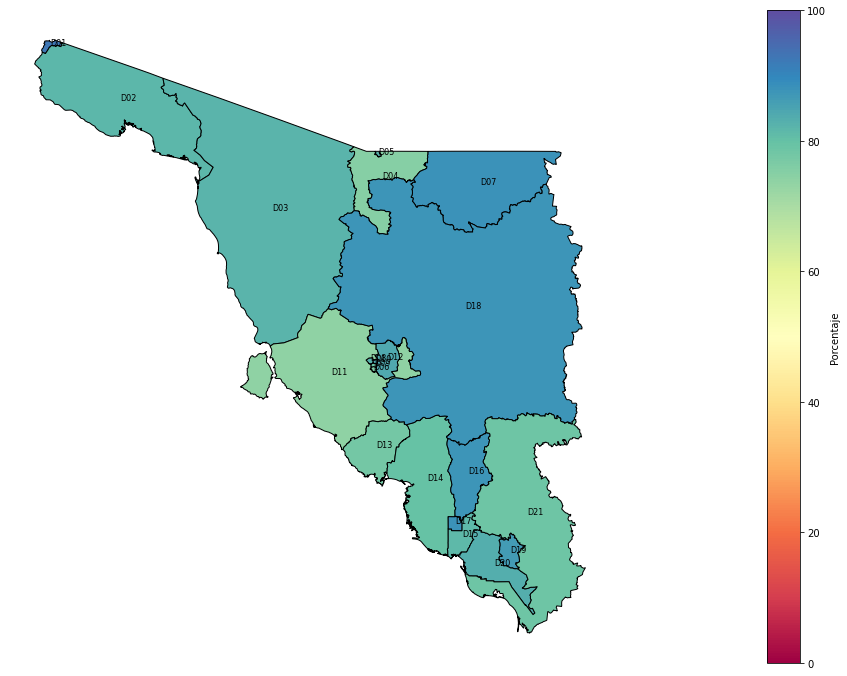

In [344]:
fig, ax = plt.subplots(1, 1,figsize=(20,12))

divider = make_axes_locatable(ax)

#cax = divider.append_axes("right", size="5%", pad=0.1)

base = gdl.plot(figsize=(20, 20),
         edgecolor = "black",
         column="Porcentaje",
         ax=ax,
         legend=True,
         cmap="Spectral",
         vmax=100,
         vmin=0,
         legend_kwds={'label': "Porcentaje",
                      'orientation': "vertical"})
# *************** ESTA PARTE ES PARA AGREGAR LAS LEYENDAS A CADA DISTRITO ***************************
texts = []
for x, y, label in zip(gdl_points.geometry.x, gdl_points.geometry.y, gdl_points["Name"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
# ***************************************************************************************************
    
plt.axis("off")

In [345]:
gdl

[(0.24682814302191466, 0.4675893886966551, 0.7100346020761246, 1.0),
 (0.3600153787004998, 0.7161860822760476, 0.6655132641291811, 1.0),
 (0.35201845444059976, 0.7072664359861591, 0.669204152249135, 1.0),
 (0.5273356401384084, 0.8106113033448674, 0.6452133794694349, 1.0),
 (0.34402153018069975, 0.6983467896962706, 0.6728950403690889, 1.0),
 (0.4955017301038063, 0.7981545559400232, 0.6456747404844291, 1.0),
 (0.23206459054209921, 0.5734717416378317, 0.7245674740484429, 1.0),
 (0.34402153018069975, 0.6983467896962706, 0.6728950403690889, 1.0),
 (0.42122260668973477, 0.7690888119953864, 0.6467512495194156, 1.0),
 (0.31203383314109956, 0.6626682045367166, 0.6876585928489043, 1.0),
 (0.5591695501730105, 0.8230680507497117, 0.6447520184544406, 1.0),
 (0.31203383314109956, 0.6626682045367166, 0.6876585928489043, 1.0),
 (0.4530565167243369, 0.7815455594002307, 0.6462898885044214, 1.0),
 (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 (0.3680123029603999, 0.7251057285659361, 0.661822376009

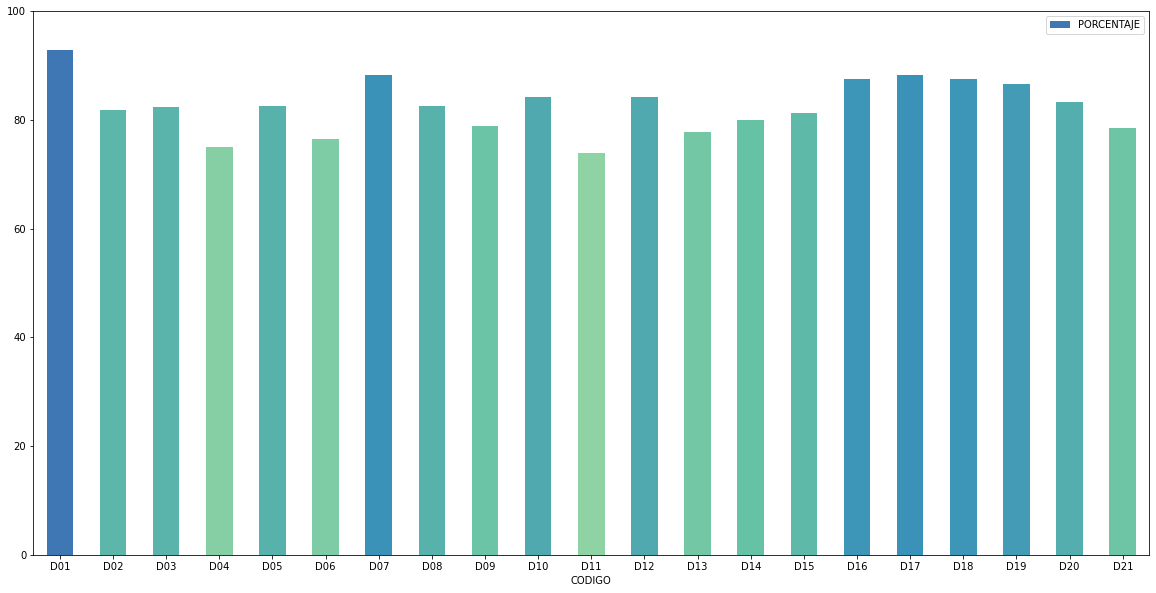

In [346]:
color = plt.get_cmap("Spectral")
colors = [ color(i/100) for i in gdl.Porcentaje.values ]
y = dl["PORCENTAJE"]
figura = dl.plot.bar(figsize=(20,10),
            rot=0,
            x="CODIGO",
            y="PORCENTAJE",
            ylim=(0,100),
            color=colors)

In [305]:
df_result = pd.DataFrame()
df_result = df_result.append(intervalo_PAN, ignore_index=True)
df_result = df_result.append(intervalo_COALICION, ignore_index=True)
df_result

,estimacion,delta,minimo,maximo,muestra
0,0.403218,0.012059,0.391159,0.415277,305
1,0.475442,0.012025,0.463418,0.487467,305


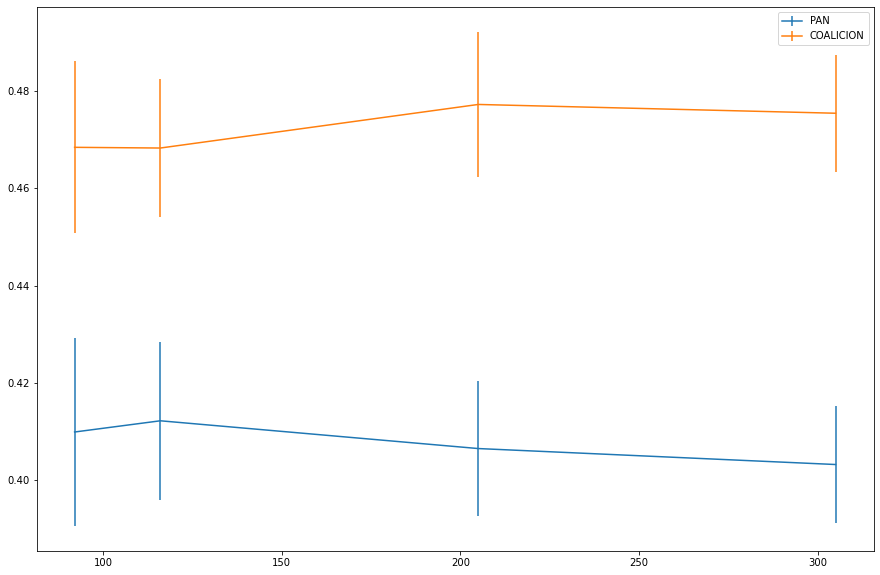

In [306]:
fig, ax = plt.subplots(figsize=(15,10))

ax.errorbar(x=historial_PAN.muestra, y=historial_PAN["estimacion"],yerr=historial_PAN["delta"], label="PAN")
ax.errorbar(x=historial_COALICION.muestra, y=historial_COALICION["estimacion"],yerr=historial_COALICION["delta"], label="COALICION")
ax.legend(numpoints=1)
plt.show()

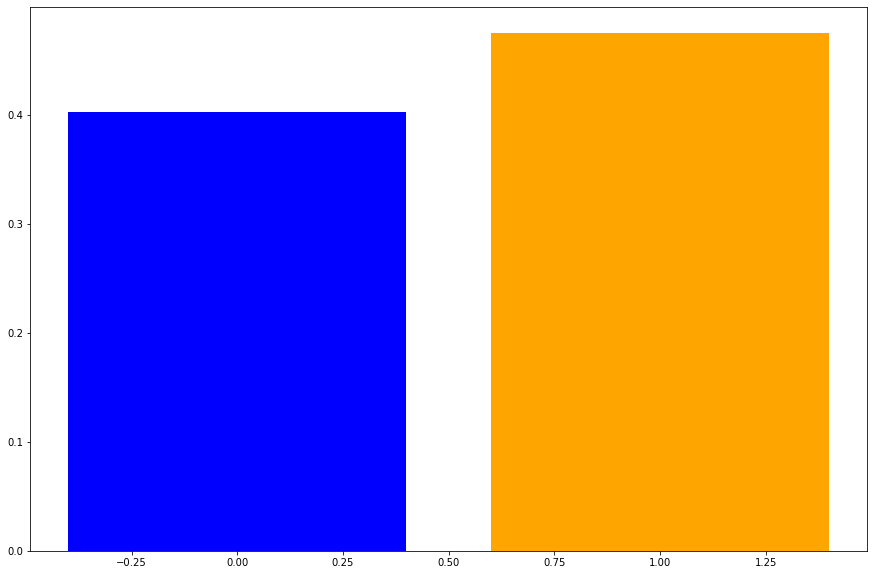

In [307]:
fig, ax = plt.subplots(figsize=(15,10))

rects1 = ax.bar( x=df_result.index, height=df_result.estimacion.values, color=['blue','orange'])

In [308]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        name='PAN',
        x=historial_PAN.muestra,
        y=historial_PAN["estimacion"],
        error_y=dict(
            type='data',
            array=historial_PAN["delta"],
            visible=True
        )
    ))
fig.add_trace(go.Scatter(
        name='COALICION',
        x=historial_COALICION.muestra,
        y=historial_COALICION["estimacion"],
        error_y=dict(
            type='data',
            array=historial_COALICION["delta"],
            visible=True
        )
    ))

fig.show()
